## Neural Language Model with Word Embeddings

In this notebook, we will be implementing Predictive Text using two different datasets. This project serves to explore the effects of the genre of a dataset on language modeling - does the genre of the dataset influence what word will come next?

We compare two datasets: the first is the Spooky Authors dataset which features creepy stories from Poe, Lovecraft, and Shelley. The second is the complete works of Nietzsche, which contains more philosophical text.

The Neural Language Model is a model which uses N-grams (N) to model language. It is a neural network that takes as input a representation of the N-1 context words, which will be the concatenated result of the word embeddings of the context words. These features are propagated forward through some hidden layers, and output a vector of the length of the vocabulary. This output vector contains a 1 in the position corresponding to the predicted next word's index, and contains 0's for all other elements - a one-hot encoding. 

This is a self-supervised problem, since the data we use is text. Based on our N-gram size, we define a context window of size N-1, and a target word. The words that appear in the context window are the predictors, and the next word is the target. Once that data point had been used for training, the next data point is generated by shifting over the context window and the target word one word to the right - essentially considering equal sized chunks of the text at a time. 

In [1]:
# Imports
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

%matplotlib inline

# Some constants
# The dimensionality of the word embeddings
EMBEDDINGS_SIZE = 300
# The size of the context window + the target word
NGRAM_SIZE = 4
# Paths for the data
SPOOKY_DATA_PATH_TEST = "./data_files/spooky_test.csv"
SPOOKY_DATA_PATH_TRAIN = "./data_files/spooky_train.csv"
NIETZSCHE_DATA_PATH = "./data_files/nietzsche_sentences.txt"

In [2]:
# Read in the data
with open(SPOOKY_DATA_PATH_TRAIN, newline='') as f:
    reader = csv.reader(f)
    reader.__next__()  # skip the column names 
    train = [row[1] for row in reader]  # Take only the text data
    
with open(SPOOKY_DATA_PATH_TEST, newline='') as f:
    reader = csv.reader(f)
    reader.__next__()  # skip the column names
    test = [row[1] for row in reader]  # Take only the text data
    
# Use all the spooky data
sentences_spooky = train + test

# Read in the Nietzsche data
with open(NIETZSCHE_DATA_PATH, 'r') as f:
  # read the lines into a list
  sentences_niet = [line.strip() for line in f]

## Data Pre-processing
We first clean and then organize our data into a list-of-list-of strings. Each inner list represents a sentence.

The input to the data cleaning step (clean_data) is a list of sentence strings.

To clean a sentence, we first change it to entirely lowercase. Next, we remove all punctuation and numbers, replacing them with a whitespace. Then, we remove quotation marks and replace them with whitespace, being careful to preserve any single quotes that are part of contractions.

After cleaning the sentence strings, we apply Python's .split() operator to each sentence in the list, resulting in a list of lists of words.

In [3]:
# Data pre-processing/cleaning

# Lowercases all words, removes punctuation, 
# and replaces all instances of a number with whitespace
def clean_data(sentences):
    regex_punctuation = r'([.,;:_"\/\\\(\)\[\]!?<>]|--)'
    regex_numbers = r'[0-9]'
    
    # Regexes matching a single quote that:
    # - precedes a word 
    # - follows a word
    # - is not next to a word
    regex_single_quote_start = "([^a-zA-Z])\\'([a-zA-Z])"
    regex_single_quote_end = "([a-zA-Z])\\'([^a-zA-Z])"
    regex_single_quote_standalone = "([^a-zA-Z])\\'([^a-zA-Z])"
    
    output = []
    
    for sent in sentences:
        tmp = sent.lower()
        tmp = re.sub(regex_punctuation, ' ', tmp)
        tmp = re.sub(regex_numbers, ' ', tmp)
        tmp = re.sub(regex_single_quote_start, r'\1 \2', tmp)
        tmp = re.sub(regex_single_quote_end, r'\1 \2', tmp)
        tmp = re.sub(regex_single_quote_standalone, r'\1 \2', tmp)
        output.append(tmp)
    
    return output

sentences_spooky = clean_data(sentences_spooky)
sentences_niet = clean_data(sentences_niet)

# Turn each sentence into a list of words
sentences_listed_spooky = [sentence.split() for sentence in sentences_spooky]
sentences_listed_niet = [sentence.split() for sentence in sentences_niet]

## Data Exploration & Statistics
We generate some basic statistics about the two corpuses, such as sentence and word count, sentence and word length, and vocab size.

In [4]:
# Data exploration

# Prints some basic statistics about our dataset:
# 1. Total Number of Sentences
# 2. Average Sentence Length in Words
# 3. Total Number of Words
# 4. Average Word Length in Characters
# 5. Vocabulary Size
# (The function returns the list of all words in the dataset)
def print_dataset_statistics(sentences):
    num_sentences = len(sentences)
    avg_sent_length = np.mean([len(sent.split()) for sent in sentences])
    all_words = []
    for sent in sentences:
        all_words.extend(sent.split())
    avg_word_length = np.mean([len(word) for word in all_words])
    num_words = len(all_words)
    vocab_size = len(set(all_words))
    
    print(f"Total sentences: {num_sentences}")
    print(f"Average sentence length: {round(avg_sent_length, 3)} words")
    print(f"Total number of words: {num_words}")
    print(f"Average word length {round(avg_word_length, 3)} characters")
    print(f"Vocabulary size: {vocab_size}")
    
    return all_words

print("---Spooky dataset statistics---")
all_words_spooky = print_dataset_statistics(sentences_spooky)
print("\n---Nietzsche dataset statistics---")
all_words_niet = print_dataset_statistics(sentences_niet)

---Spooky dataset statistics---
Total sentences: 27971
Average sentence length: 26.633 words
Total number of words: 744958
Average word length 4.483 characters
Vocabulary size: 29027

---Nietzsche dataset statistics---
Total sentences: 103741
Average sentence length: 8.615 words
Total number of words: 893702
Average word length 4.647 characters
Vocabulary size: 31371


## Create Word Embeddings
We create separate word embeddings for each dataset using word2vec. Then, we evaluate the differences between these embeddings in two ways:

* Finding most-similar words to common words, and finding the least-similar word from a group of words, all but one of which share a category.

* Visualize these two embeddings using TSNE to project the data down to 2 dimensions. We highlight the positions of specific related words in the graphs to evaluate the differences between relative positions of related words.

In [5]:
# Create the embeddings, save the KeyedVector, toss the model
model_spooky = Word2Vec(sentences=sentences_listed_spooky, size=EMBEDDINGS_SIZE, sg=1, window=5, min_count=1)
model_niet = Word2Vec(sentences=sentences_listed_niet, size=EMBEDDINGS_SIZE, sg=1, window=5, min_count=1)

spooky_embeddings = model_spooky.wv
niet_embeddings = model_niet.wv

del model_spooky
del model_niet

In [6]:
# This function prints some quick similarities and comparisons for the given embeddings
def quick_evaluate_embeddings(embeddings):
    
    similar_to_king = embeddings.most_similar('king')[0][0]
    similar_to_horse = embeddings.most_similar('horse')[0][0]
    similar_to_man = embeddings.most_similar('man')[0][0]
    king_minus_man_plus_woman = embeddings.most_similar(positive=['king', 'woman'], negative=['man'])[0][0]
    odd_one_out_food = embeddings.doesnt_match(('bread', 'meat', 'vegetables', 'peasant'))
    odd_one_out_days = embeddings.doesnt_match(('monday', 'wednesday', 'friday', 'favorite'))
    odd_one_out_animals = embeddings.doesnt_match(('cat', 'dog', 'sheep', 'wolf', 'hose'))

    print(f"Word most similar to 'king': {similar_to_king}")
    print(f"Word most similar to 'horse': {similar_to_horse}")
    print(f"Word most similar to 'man': {similar_to_man}")
    print(f"King - Man + Woman: {king_minus_man_plus_woman}")
    print(f"Was the model able to distinguish 'peasant' from food? {odd_one_out_food == 'peasant'}")
    print(f"Was the model able to distinguish 'favorite' from weekdays? {odd_one_out_days == 'favorite'}")
    print(f"Was the model able to distinguish 'train' from animals? {odd_one_out_animals == 'train'}")
    

print('Output for Spooky Embeddings:')
quick_evaluate_embeddings(spooky_embeddings)
print('--------------------------------------')
print('Output for Nietzsche Embeddings')
quick_evaluate_embeddings(niet_embeddings)

Output for Spooky Embeddings:
Word most similar to 'king': title
Word most similar to 'horse': wrist
Word most similar to 'man': woman
King - Man + Woman: accompanied
Was the model able to distinguish 'peasant' from food? True
Was the model able to distinguish 'favorite' from weekdays? True
Was the model able to distinguish 'train' from animals? False
--------------------------------------
Output for Nietzsche Embeddings
Word most similar to 'king': soothsayer
Word most similar to 'horse': wolves
Word most similar to 'man': priest
King - Man + Woman: soothsayer
Was the model able to distinguish 'peasant' from food? True
Was the model able to distinguish 'favorite' from weekdays? True
Was the model able to distinguish 'train' from animals? False


/usr/local/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [7]:
# Building the t-SNE projection

# This is the V x E matrix; the full-length embedding for each vocab word
# Each unique word w_i represents the row V_i
# Each row is a vector of length E which corresponds to that word's embedding 
embedding_matrix_spooky = spooky_embeddings[spooky_embeddings.vocab]
embedding_matrix_niet = niet_embeddings[niet_embeddings.vocab]

vocab_size_spooky = embedding_matrix_spooky.shape[0]
vocab_size_niet = embedding_matrix_niet.shape[0]

print(f"Original shape of the spooky matrix: {embedding_matrix_spooky.shape}")  # (31851, 300)
print(f"Original shape of the philosophical matrix: {embedding_matrix_niet.shape}")  # (31851, 300)


# We first run PCA and keep the first num_components dimensions before we pass into t-SNE
num_components = 50
random_seed = 100

pca_spooky = PCA(n_components=num_components)
pca_embeddings_spooky = pca_spooky.fit_transform(embedding_matrix_spooky)
pca_niet = PCA(n_components=num_components)
pca_embeddings_niet = pca_niet.fit_transform(embedding_matrix_niet)

print(f"New shape of the spooky matrix: {pca_embeddings_spooky.shape}")  # (31851, 50)
print(f"New shape of the philosophical matrix: {pca_embeddings_niet.shape}")  # (31851, 50)

# Since we ran PCA and kept only the first few dimensions, we want to know how much
# of the original information is still preserved in this projection. The concept of
# "explained variance" is helpful here. Our original 300-dimensional vector space has 
# a certain amount of variance among the data. This is our "total variance". When we 
# project to 50 dimensions, we lose some of that variance, since we lose dimensions along
# which our data can vary. We calculate the total amount of variance in our 50-dimensional
# space and divide that number by our total variance. This yields the amount of variance 
# preserved after our projection. So while our data might not have *all* of the original
# variance, we can still see that it has a significant percentage of the total variance, and
# so we only lose a small amount of information while reducing our space a lot.
print(f"SPOOKY: Cumulative explained variance of first {num_components} PC dimensions: {100 * round(np.sum(pca_spooky.explained_variance_ratio_), 3)}%")
print(f"PHILOSOPHICAL: Cumulative explained variance of first {num_components} PC dimensions: {100 * round(np.sum(pca_niet.explained_variance_ratio_), 3)}%")

Original shape of the spooky matrix: (29027, 300)
Original shape of the philosophical matrix: (31371, 300)
New shape of the spooky matrix: (29027, 50)
New shape of the philosophical matrix: (31371, 50)
SPOOKY: Cumulative explained variance of first 50 PC dimensions: 99.19999837875366%
PHILOSOPHICAL: Cumulative explained variance of first 50 PC dimensions: 98.29999804496765%


In [8]:
# Now we run t-SNE
tsne_spooky = TSNE(n_components=2, perplexity=45, verbose=True, random_state=random_seed, n_iter=500)
tsne_embeddings_spooky = tsne_spooky.fit_transform(pca_embeddings_spooky)

tsne_niet = TSNE(n_components=2, perplexity=45, verbose=True, random_state=random_seed, n_iter=500)
tsne_embeddings_niet = tsne_niet.fit_transform(pca_embeddings_niet)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 29027 samples in 0.091s...
[t-SNE] Computed neighbors for 29027 samples in 27.143s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29027
[t-SNE] Computed conditional probabilities for sample 2000 / 29027
[t-SNE] Computed conditional probabilities for sample 3000 / 29027
[t-SNE] Computed conditional probabilities for sample 4000 / 29027
[t-SNE] Computed conditional probabilities for sample 5000 / 29027
[t-SNE] Computed conditional probabilities for sample 6000 / 29027
[t-SNE] Computed conditional probabilities for sample 7000 / 29027
[t-SNE] Computed conditional probabilities for sample 8000 / 29027
[t-SNE] Computed conditional probabilities for sample 9000 / 29027
[t-SNE] Computed conditional probabilities for sample 10000 / 29027
[t-SNE] Computed conditional probabilities for sample 11000 / 29027
[t-SNE] Computed conditional probabilities for sample 12000 / 29027
[t-SNE] Computed conditional probabilities for s

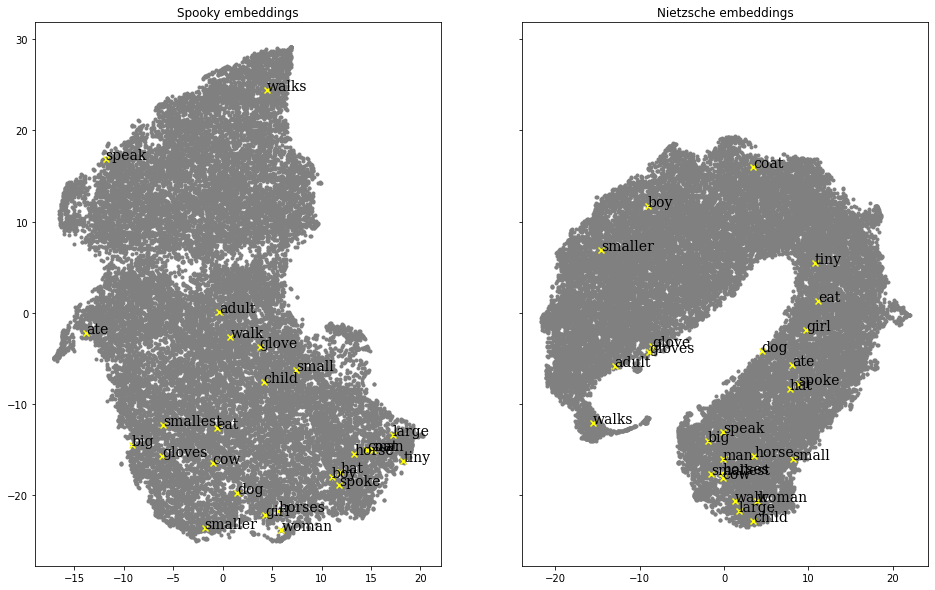

In [9]:
# Visualizing the data

vis_x_spooky = tsne_embeddings_spooky[:, 0]
vis_y_spooky = tsne_embeddings_spooky[:, 1]

vis_x_niet = tsne_embeddings_niet[:, 0]
vis_y_niet = tsne_embeddings_niet[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 10))

ax1.scatter(vis_x_spooky, vis_y_spooky, c='grey', marker='.')
ax2.scatter(vis_x_niet, vis_y_niet, c='grey', marker='.')


def visualize_clusters(current_ax, embeddings, tsne_model):
    # We highlight the location of several words of interest on this chart.
    words_of_interest = ('man', 'woman', 'boy', 'girl', 'child', 'adult',
                         'coat', 'hat',  'glove', 'gloves',
                         'dog', 'horse', 'horses', 'cow',
                         'large', 'big', 'tiny', 'small', 'smaller', 'smallest', 
                        'walk', 'walks', 'speak', 'spoke', 'eat', 'ate')
    vectors_of_interest = []
    # Need to look up the index of the word to find its corresponding t-SNE vector
    for word in words_of_interest:
        idx_of_word = embeddings.vocab[word].index
        vectors_of_interest.append(tsne_model.embedding_[idx_of_word])

    # Text styling parameters
    font= {'family':'serif','color':'black','weight':'normal','size':14}

    # Draw the words of interest on and label them
    for idx, vec in enumerate(vectors_of_interest):
        current_ax.scatter(vec[0], vec[1], c='yellow', marker='x')
        current_ax.text(vec[0], vec[1], words_of_interest[idx], fontdict=font)

        
visualize_clusters(ax1, spooky_embeddings, tsne_spooky)
visualize_clusters(ax2, niet_embeddings, tsne_niet)
ax1.set_title('Spooky embeddings')
ax2.set_title('Nietzsche embeddings')
plt.show()

## Language Model with Feedforward Neural Network
We will first encode our texts into integers to make it easier to create one-hot encodings.
Given the previous N-1 context words, the model will attempt to predict the Nth word. So the input to our neural network will need to be a representation of the N-1 context words. Since we are using N-gram size of N=4, then given 3 context words, the model must predict the 4th word. We represent the words using their word embeddings. 

The input to the model will be a vector of shape (900,) which will be the result of concatenating the word embeddings of the 3 context words together. The output dimension of our network will be |V|, the size of the vocabulary. The model will output the one-hot encoding of the predicted 4th word.

In [10]:
from math import floor
from random import shuffle
from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding

In [11]:
# We will be feeding into our model a sequence of vectors, each of shape (900,), 
# representing the concatenated word embeddings of the 3 context words. The output will be 
# a one-hot encoding of the predicted word. In order to train our model, we will format our
# data in this format. To do this, we will create a data generator that yields a tuple (X, y), 
# where X is the (900,) vector of word embeddings and y is the one-hot encoded output word.


# This function returns the concatenated word embeddings of the supplied words
# It takes in a list of context words and an embedding mapping, and returns the
# concatenated result. 
# Inputs:
#    context (list)                          - the list of length (n_gram - 1) context words
#    embeddings (gensim.models.KeyedVectors) - the mapping from word -> word embeddings used to represent the words
# Returns:
#    numpy array of shape (n_gram - 1) x embedding_size, ie. (900,)
def concat_embeddings(context, embeddings):
    embedded_contexts = [embeddings.get_vector(word) for word in context]
    concatted = np.concatenate(embedded_contexts)
    return np.reshape(concatted, newshape=(1, (NGRAM_SIZE - 1) * EMBEDDINGS_SIZE))
    

# This function returns the one-hot representation of the supplied word.
# Inputs:
#    word (str)                                     - the word to convert to one-hot encoding
#    word_mapping (dict)                            - the mapping from word -> index used to encode the sentneces
# Returns:
#    numpy array of shape |V|, ie. the size of the vocabulary
def to_onehot(word, word_mapping):
    idx = word_mapping.get(word).index
    vocab_size = len(list(word_mapping.keys())) 
    onehot = to_categorical([[idx]], num_classes=vocab_size)
    return np.reshape(onehot, newshape=(onehot.shape[0], onehot.shape[-1]))


# This is the data generator that yields our data as an X,y pair. 
# Inputs:
#   data (list)                                    - the list of list of words, ie. the sentences
#   n_gram (int)                                   - the n-gram order to be used in the neural language model
#   tokenizer (keras.preprocessing.text.Tokenizer) - the mapping from word -> index used to encode the sentneces
#   embeddings (gensim.models.KeyedVectors)        - the mapping from word -> word embeddings used to represent the words
# Yields:
#   tuple - (X, y)
#   X: numpy array of shape (900,)
#   y: numpy array of shape (|V|,)
def data_generator(data, n_gram, embeddings):
    tokenizer = embeddings.vocab
    for sent in data:
        # We need at least n_gram words to run the model
        # If we don't have enough, ignore the current sentence
        if len(sent) < n_gram:
            continue
        # For a sentence of length S, we will have (S - n_gram) outputs from the generator
        for i in range(len(sent) + 1 - n_gram):
            # Define the context words
            context_words = sent[i : i + n_gram - 1]
            # Define the word we are trying to predict
            pred_word = sent[i + n_gram - 1]
            # Get the concatenated word embeddings for our context words
            embedded_context_words = concat_embeddings(context_words, embeddings)
            # Get the one-hot encoding of our context word
            onehot_pred_word = to_onehot(pred_word, tokenizer)
            # Yield the data
            yield embedded_context_words, onehot_pred_word
            

# Wrapper class for the data generator defined above
# Subclasses keras.utils.Sequence, allowing us to reset the generator after each epoch
# Inputs:
#   data (list)                                    - the list of list of words, ie. the sentences
#   n_gram (int)                                   - the n-gram order to be used in the neural language model
#   tokenizer (keras.preprocessing.text.Tokenizer) - the mapping from word -> index used to encode the sentneces
#   embeddings (gensim.models.KeyedVectors)        - the mapping from word -> word embeddings used to represent the words
# Yields:
#   tuple - (X, y)
#   X: numpy array of shape (900,)
#   y: numpy array of shape (|V|,)
class data_generator_resettable(Sequence):
    def __init__(self, data, n_gram, embeddings):
        self.data = data
        self.n_gram = n_gram
        self.embeddings = embeddings
        self.generator = data_generator(data, n_gram, embeddings)
        self.length = self.get_length()
        self.index = 0
        
    # Returns the batch at the given index
    # Since each batch will be a single (X, y) pair, we can just return the next item
    # If we hit the end of the line, reset the generator and try again
    def __getitem__(self, index):
        try:
            return next(self.generator)
        except StopIteration:
            self.on_epoch_end()
            return self.__getitem__(index)
    
    # Returns the stored length of the generator
    def __len__(self):
        return self.length
        
    # Finds the length of the generator and saves it
    # This method is only called once when the generator is initialized
    def get_length(self):
        # For a sentence of length S, we will have (S - n_gram + 1) outputs from the generator
        count = 0
        for sent in self.data:
            count += max(len(sent) - NGRAM_SIZE + 1, 0)
        if count < 1:
            raise Exception("No valid examples in the data")
        return count
        
    # Callback method after each epoch
    # We shuffle the data and reinitialize the generator
    def on_epoch_end(self):
        shuffle(self.data)
        self.index = 0
        self.generator = data_generator(self.data, self.n_gram, self.embeddings)

In [12]:
# Sample data to verify the output of the data generator
test_data = [['of', 'the', 'we', 'are', 'have'], 
             ['not', 'enough', 'here'], 
             ['is', 'are', 'we', 'is'],
             ['this', 'one', 'has', 'more', 'in', 'it'],
             ['and', 'here', 'is', 'the', 'last', 'book']]
data_gen = data_generator_resettable(test_data, NGRAM_SIZE, spooky_embeddings)
print(f"Size of generator - {data_gen.length}")
first_out = data_gen.__getitem__(0)
data_gen.on_epoch_end()
print(f"Shape of X, y: {first_out[0].shape} {first_out[1].shape}")

Size of generator - 9
Shape of X, y: (1, 900) (1, 29027)


In [13]:
# We've verified that the data generator works correctly
# We can now define the data generator for our actual data

generator_spooky = data_generator_resettable(sentences_listed_spooky, NGRAM_SIZE, spooky_embeddings)
generator_niet = data_generator_resettable(sentences_listed_niet, NGRAM_SIZE, niet_embeddings)

In [14]:
# Now we create the models

vocab_size_spooky = len(spooky_embeddings.vocab.keys())
vocab_size_niet = len(niet_embeddings.vocab.keys())

neural_lm_spooky = Sequential()
h1 = Dense(128, name='h1', input_shape=(1, (NGRAM_SIZE - 1) * EMBEDDINGS_SIZE), activation='tanh')

neural_lm_spooky.add(h1)
neural_lm_spooky.add(Dense(50, name='h2', activation='relu'))
neural_lm_spooky.add(Dense(vocab_size_spooky, name='output', activation='softmax'))

neural_lm_spooky.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("Spooky model summary:")
neural_lm_spooky.summary()

neural_lm_niet = Sequential()
neural_lm_niet.add(Dense(128, name='h1', input_shape=(1, (NGRAM_SIZE - 1) * EMBEDDINGS_SIZE), activation='tanh'))
neural_lm_niet.add(Dense(50, name='h2', activation='relu'))
neural_lm_niet.add(Dense(vocab_size_niet, name='output', activation='softmax'))

neural_lm_niet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print("Nietzsche model summary:")
neural_lm_niet.summary()

Spooky model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   (None, 1, 128)            115328    
_________________________________________________________________
h2 (Dense)                   (None, 1, 50)             6450      
_________________________________________________________________
output (Dense)               (None, 1, 29027)          1480377   
Total params: 1,602,155
Trainable params: 1,602,155
Non-trainable params: 0
_________________________________________________________________
Nietzsche model summary:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   (None, 1, 128)            115328    
_________________________________________________________________
h2 (Dense)                   (None, 1, 50) 

In [15]:
# Training the model
neural_lm_spooky.fit(generator_spooky, verbose=2, epochs=1)

661051/661051 - 4314s - loss: 10.3584 - accuracy: 0.0816


In [ ]:
# Training the model
neural_lm_niet.fit(generator_niet, verbose=2, epochs=1)

## Evaluation
Now that we have trained our models, we would like to evaluate them. 
The purpose of a language model is to predict the next word in the sentence, 
and so we will be comparing the outputs 

In [ ]:
# This function will generate a sequence from the model.
# Inputs:
#    model (keras.Model)                            - the model to be used
#    tokenizer (keras.preprocessing.text.Tokenizer) - the mapping from word -> index used to encode the sentneces
#    seed (list)                                    - the sequence of N-1 context words from which to begin the sequence
#    n_words (int)                                  - the length of the output sequence
def generate_seq(model, seed, n_words, embeddings):
    output = seed
    i = 0
    index_to_word = {v.index: k for k, v in embeddings.vocab.items()}
    while len(output) < n_words:
        context = output[i : i + NGRAM_SIZE - 1]
        embedded = concat_embeddings(context, embeddings)
        prob_distr = model.predict(embedded)
        next_word_idx = np.argmax(prob_distr)
        output.append(index_to_word[next_word_idx])
        i += 1
    return output


niet_seed = [["in", "the", "belief"],
             ["we", "need", "it"],
             ["tried", "to", "describe"],
             ["for", "life", "and"],
             ["tell", "me", "that"],
             ["great", "historical", "movement"],
             ["at", "all", "costs"],
             ["i", "gain", "an"],
             ["these", "thoughts", "are"],
             ["as", "a", "fault"],
             ["even", "if", "it"],
             ["be", "a", "virtue"],
             ["a", "child", "of"],
             ["i", "must", "admit"],
             ["man", "cannot", "see"],
             ["simply", "to", "live"],
             ["to", "live", "without"],
             ["the", "beast", "wants"],
             ["but", "he", "forgets"],
             ["i", "always", "forget"]]

spooky_seed = [["if", "a", "fire"],
               ["as", "i", "urged"],
               ["the", "tone", "metaphysical"],
               ["the", "offspring", "of"],
               ["persuading", "the", "widow"],
               ["when", "i", "arose"],
               ["tears", "in", "my"],
               ["nothing", "was", "elicited"],
               ["the", "lost", "inheritance"],
               ["could", "almost", "see"],
               ["freak", "of", "fancy"],
               ["grapple", "not", "now"],
               ["upon", "the", "figure"],
               ["restrain", "your", "impatience"],
               ["he", "is", "dead"],
               ["i", "felt", "much"],
               ["and", "this", "fall"],
               ["during", "this", "shocking"],
               ["was", "he", "murdered"],
               ["darkness", "had", "no"]]


print("Spooky sentences:")
print("================")
for each_seed in spooky_seed:
    print(" ".join(generate_seq(neural_lm_spooky, each_seed, 20, spooky_embeddings)) + "\n")
    
print("Philosophical sentences:")
print("================")
for each_seed in niet_seed:
    print(" ".join(generate_seq(neural_lm_niet, each_seed, 20, niet_embeddings)) + "\n")